In [19]:
from pathlib import Path
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("../../")
from smpl2motorica.utils.bvh import BVHParser
from smpl2motorica.utils.pymo.preprocessing import MocapParameterizer

In [20]:
from smpl2motorica.keypoint_fk import ForwardKinematics

In [21]:
# cwd
cwd = Path.cwd()
print(f"Current working directory: {cwd}")
# define some variables
motorica_data_root = Path("/fs/nexus-projects/PhysicsFall/data/motorica_dance_dataset")

motorica_motion_path = (
    motorica_data_root
    / "bvh"
    / "kthjazz_gCH_sFM_cAll_d02_mCH_ch01_beatlestreetwashboardbandfortyandtight_003.bvh"
)
if not motorica_motion_path.exists():
    raise FileNotFoundError(f"Motion file {motorica_motion_path} does not exist. ")

Current working directory: /fs/nexus-projects/PhysicsFall/smpl2motorica/playground


In [22]:

def get_motorica_skeleton_names():
    return [
        "Head",
        "Hips",
        "LeftArm",
        "LeftFoot",
        "LeftForeArm",
        "LeftHand",
        "LeftLeg",
        "LeftShoulder",
        # "LeftToeBase",
        "LeftUpLeg",
        "Neck",
        "RightArm",
        "RightFoot",
        "RightForeArm",
        "RightHand",
        "RightLeg",
        "RightShoulder",
        # "RightToeBase",
        "RightUpLeg",
        "Spine",
        "Spine1",
    ]

def expand_motorica_skeleton(skeleton: list):
    expanded_skeleton = [f"{joint}_{axis}rotation" for joint in skeleton for axis in ['X', 'Y', 'Z']]
    return expanded_skeleton
    


def motorica_draw_stickfigure3d(
    fig,
    mocap_track,
    frame,
    data=None,
    joints=None,
    draw_names=True,
):
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(122, projection="3d")
    # ax.view_init(elev=0, azim=120)

    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints

    if data is None:
        df = mocap_track.values
    else:
        df = data

    for idx, joint in enumerate(joints_to_draw):
        parent_x = df["%s_Xposition" % joint][frame]
        parent_y = df["%s_Zposition" % joint][frame]
        parent_z = df["%s_Yposition" % joint][frame]
        # ^ In mocaps, Y is the up-right axis

        ax.scatter(xs=parent_x, ys=parent_y, zs=parent_z, alpha=0.6, c="b", marker="o")
        

        children_to_draw = [
            c for c in mocap_track.skeleton[joint]["children"] if c in joints_to_draw
        ]

        for c in children_to_draw:
            child_x = df["%s_Xposition" % c][frame]
            child_y = df["%s_Zposition" % c][frame]
            child_z = df["%s_Yposition" % c][frame]
            # ^ In mocaps, Y is the up-right axis

            ax.plot(
                [parent_x, child_x],
                [parent_y, child_y],
                [parent_z, child_z],
                # "k-",
                lw=2,
                c="black",
            )

        if draw_names:
            ax.text(
                x=parent_x - 0.5,
                y=parent_y - 0.5,
                z=parent_z - 0.5,
                s=f"{idx}:{joint}",
                fontsize=5,
            )

    return ax

In [23]:
def skeleton_scaler(skeleton, ratio):
    """
    Scales the offsets of each joint in the skeleton by a given ratio.

    Args:
        skeleton (dict): A dictionary representing the skeleton, where each key is a joint name and the value is another dictionary containing joint properties, including "offsets".
        ratio (float): The scaling factor to apply to the offsets.

    Returns:
        dict: The scaled skeleton with updated offsets.
    """
    for joint in skeleton:
        skeleton[joint]["offsets"] = np.array(skeleton[joint]["offsets"]) * ratio
    return skeleton

In [24]:
# load the motion
bvh_parser = BVHParser()
motorica_dummy_data = bvh_parser.parse(motorica_motion_path)
motorica_dummy_df = motorica_dummy_data.values

In [25]:
# joints_to_keep = get_motorica_skeleton_names()
# expanded_skeleton = expand_motorica_skeleton(joints_to_keep)
# # filter the skeleton
# motorica_dummy_data.skeleton = {
#     joint: motorica_dummy_data.skeleton[joint]
#     for joint in motorica_dummy_data.skeleton
#     if joint in joints_to_keep
# }

# # filter out the data
# motorica_dummy_data.values = motorica_dummy_df[expanded_skeleton]


In [26]:
# # Filter out unnecessary columns
# joints_to_keep = get_motorica_skeleton_names()
# expand_joints_to_keep = expand_motorica_skeleton(joints_to_keep)
# # append location to the joint names
# expand_joint_with_location = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition'] + expand_joints_to_keep
# # filter out unnecessary joints
# motorica_dummy_df = motorica_dummy_df[expand_joint_with_location]
position_mocap = MocapParameterizer("position").fit_transform(
        [motorica_dummy_data]
    )[0]
position_df = position_mocap.values

In [27]:
frame = 10

/tmp/ipykernel_1554932/3154434633.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_x = df["%s_Xposition" % joint][frame]
/tmp/ipykernel_1554932/3154434633.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_y = df["%s_Zposition" % joint][frame]
/tmp/ipykernel_1554932/3154434633.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_z = df["%s_Yposition" % joint][frame]
/tmp/ipykernel_1554932/3154434633.py:69:

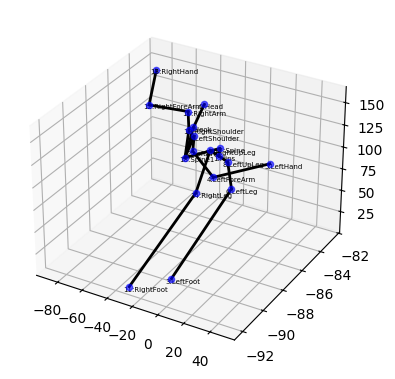

In [28]:
# visualize the motion
fig = plt.figure(figsize=(10, 5))
motorica_draw_stickfigure3d(fig, position_mocap, frame, joints = get_motorica_skeleton_names())
plt.show()

In [29]:
joints_to_keep = get_motorica_skeleton_names()
expanded_skeleton = expand_motorica_skeleton(joints_to_keep)
# filter the skeleton
my_skeleton = {
    joint: motorica_dummy_data.skeleton[joint]
    for joint in motorica_dummy_data.skeleton
    if joint in joints_to_keep
}
my_skeleton

{'Hips': {'parent': None,
  'channels': ['Xposition',
   'Yposition',
   'Zposition',
   'Zrotation',
   'Xrotation',
   'Yrotation'],
  'offsets': [-20.4624, 86.4926, -96.2418],
  'order': 'ZXY',
  'children': ['Spine', 'LeftUpLeg', 'RightUpLeg']},
 'Spine': {'parent': 'Hips',
  'channels': ['Zrotation', 'Xrotation', 'Yrotation'],
  'offsets': [0.0, 7.77975, 0.0],
  'order': 'ZXY',
  'children': ['Spine1']},
 'Spine1': {'parent': 'Spine',
  'channels': ['Zrotation', 'Xrotation', 'Yrotation'],
  'offsets': [-1.5767e-05, 22.6566, 7.36298e-05],
  'order': 'ZXY',
  'children': ['Neck', 'LeftShoulder', 'RightShoulder']},
 'Neck': {'parent': 'Spine1',
  'channels': ['Zrotation', 'Xrotation', 'Yrotation'],
  'offsets': [0.0, 24.9469, 0.0],
  'order': 'ZXY',
  'children': ['Head']},
 'Head': {'parent': 'Neck',
  'channels': ['Zrotation', 'Xrotation', 'Yrotation'],
  'offsets': [0.0, 14.7056, 1.8975],
  'order': 'ZXY',
  'children': ['Head_Nub']},
 'LeftShoulder': {'parent': 'Spine1',
  'chann

In [30]:
fk = ForwardKinematics(skeleton = my_skeleton)

In [31]:
position = fk.forward(motorica_dummy_df)

In [32]:
position_df = fk.convert_to_dataframe(position)

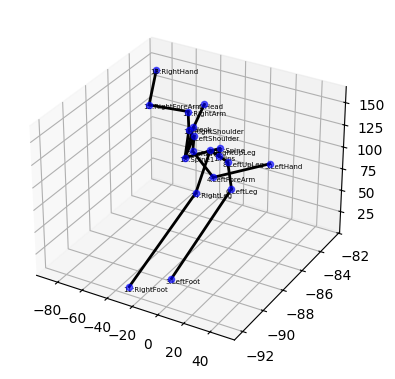

In [33]:
fig = plt.figure(figsize=(10, 5))
motorica_draw_stickfigure3d(fig, position_mocap, frame, joints = get_motorica_skeleton_names(), data = position_df)
plt.show()